In [15]:
# Refactoring tips : https://pytorch.org/tutorials/beginner/nn_tutorial.html
# Module forward hook : https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/
# Module, Sequential, and organizing better : https://github.com/FrancescoSaverioZuppichini/Pytorch-how-and-when-to-use-Module-Sequential-ModuleList-and-ModuleDict/blob/master/README.md
# writing your own optimizer http://mcneela.github.io/machine_learning/2019/09/03/Writing-Your-Own-Optimizers-In-Pytorch.html
# torch tensor quick start operatiosn https://jhui.github.io/2018/02/09/PyTorch-Basic-operations/

In [16]:
import os
import torch
from torch import nn
import numpy as np

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import matplotlib.pyplot as plt
#%matplotlib widget

# Dataset

In [17]:
class XORDataset(Dataset):
    """XOR dataset."""

    def __init__(self, num_samples = 200):
        """
        Args:
            num_samples: number of samples to generate
        """

        self.num_samples = num_samples
        self.X = np.random.randint(0,high=2, size=num_samples*2).reshape((num_samples, 2)).astype(np.float32)
        self.y = np.logical_xor(self.X[:,0], self.X[:,1]).reshape((num_samples,1)).astype(np.float32)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #sample = {'X': self.X[idx], 'y': self.y[idx]}
        sample = (self.X[idx], self.y[idx])

        return sample

# Dataloaders, get_data

In [18]:
def get_data(batch_size):

    datasets = {
        'train' : XORDataset(200),
        'valid' : XORDataset(50),
    }
    loaders = {
    'train' : torch.utils.data.DataLoader(datasets['train'],  
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers=1),
    'valid' : torch.utils.data.DataLoader(datasets['valid'], 
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers=1),
    }
    return datasets, loaders
    

# Net model
## class XORnet

In [19]:
class XORnet(nn.Module):

    def __init__(self):
        super(XORnet, self).__init__()

        self.fc1=nn.Linear(2, 2)
        self.sig1=nn.Sigmoid()
        self.fc2=nn.Linear(2, 1)
        self.sig2=nn.Sigmoid()
        
        self.activations=[0 for i in range(3)] # 3 "layers" : input/hidden/output

        # custom weight initialization

        for layer in [self.fc1, self.fc2]:
            nn.init.normal_(layer.weight)


    def forward(self, x):
        '''Forward pass'''
        
        x2 = self.fc1(x)
        x2 = self.sig1(x2)
        x3 = self.fc2(x2)
        x3 = self.sig2(x3)
        self.store_activations(x, x2, x3)
        return x3

    def store_activations(self, x, x2, x3):
        self.activations[0] = x
        self.activations[1] = x2
        self.activations[2] = x3

In [20]:
class learner():

    def __init__(self, model, lr, opt_name, loss_fn=nn.MSELoss()):
        self.model = model
        self.lr = lr
        self.loss_fn = loss_fn
        optimizers = {
            'adam': torch.optim.Adam(model.parameters(), lr = lr) ,
            'SGD': torch.optim.SGD(self.model.parameters(), lr = lr)
        }
        self.opt = optimizers[opt_name]

    def get_model(self):
        return self.model, self.opt, self.loss_fn

In [21]:
# to do : determine learning rate by grid search
'''To make comparisons easier, we use the
same learning rate η for FF+FB and FF, determined by grid search. 
We average 10 runs, taking g = 0.7 and η = 0.025 for both networks. The number of
epochs is capped to 300 epochs. With these constraints, η is optimized (by grid search) for the smallest
number of epochs of the two networks that reached 100% training accuracy in 10 runs.'''

'To make comparisons easier, we use the\nsame learning rate η for FF+FB and FF, determined by grid search. \nWe average 10 runs, taking g = 0.7 and η = 0.025 for both networks. The number of\nepochs is capped to 300 epochs. With these constraints, η is optimized (by grid search) for the smallest\nnumber of epochs of the two networks that reached 100% training accuracy in 10 runs.'

# class statsLogger

In [22]:
class statsLogger():
    def __init__(self):
        self.accuracies=[]   # accuracy for each epoch
        self.losses=[]
        self.epochs=0
        self.minibatches=0
        self.samples=0
        self.all_minibatches_accuracies=[]  # accuracies for all minibatches in all epochs
        self.all_minibatches_losses=[]  # accuracies for all minibatches in all epochs

    def startEpoch(self):
        self.epoch_total_samples=0
        self.epoch_total_minibatches=0
        self.epoch_correct_samples=0
        self.minibatch_losses=[]  # losses for all minibatches in the epoch
        

    def getMinibatchStats(self, pred, yb, loss, pref_fn=lambda pred : (pred>0.5).float() ):
        #Accuracy
        predicted = pref_fn(pred)
        minibatch_num_corrects = (predicted == yb).float().sum()
        minibatch_total = pred.shape[0]
        self.epoch_total_samples += minibatch_total
        self.epoch_correct_samples += minibatch_num_corrects.item()
        self.minibatch_losses.append(loss.item())
        self.all_minibatches_losses.append(loss.item())
        self.all_minibatches_accuracies.append(100 *  minibatch_num_corrects.item() / minibatch_total)
        self.minibatches+=1
        self.epoch_total_minibatches+=1

    def endEpoch(self):
        self.losses.append(np.array(self.minibatch_losses).mean())
        self.accuracies.append(100 * self.epoch_correct_samples / self.epoch_total_samples)
        self.epochs+=1
        self.samples+=self.epoch_total_samples
        
    

# function plotTraining

In [23]:
def plotTraining(loggers: list, learner: learner):
    
    fig, axs= plt.subplots(1, 2, figsize=(18, 6))  
    plt.title('XOR Dataset Opt={}, lr={}, loss_fn={}'
        .format(learner.opt.__class__.__name__, learner.lr, learner.loss_fn.__class__.__name__))

    axs[0].plot(loggers['train'].losses, label='Train loss')
    axs[0].plot(loggers['valid'].losses, label='Valid loss')
    axs[0].set_title('Losses')
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('loss')

    axs[1].plot(loggers['train'].accuracies, label='Train accuracy')
    axs[1].plot(loggers['valid'].accuracies, label='Valid accuracy')
    axs[1].set_title('Accuracies')  
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('Accuracy')

    plt.legend()
    plt.show()

In [24]:
def plotTrainingPerMiniBatch(loggers: list, learner: learner):
    
    fig, axs= plt.subplots(1, 2, figsize=(18, 6))  
    plt.title('XOR Dataset Opt={}, lr={}, loss_fn={}'
        .format(learner.opt.__class__.__name__, learner.lr, learner.loss_fn.__class__.__name__))

    axs[0].plot(loggers['train'].all_minibatches_losses, label='Minibatch Train loss')
    #axs[0].plot(loggers['valid'].all_minibatches_losses, label='Minibatch Valid loss')
    axs[0].set_title('Losses')
    axs[0].set_xlabel('Minibatches')
    axs[0].set_ylabel('loss')

    axs[1].plot(loggers['train'].all_minibatches_accuracies, label='Minibatch Train accuracy')
    #axs[1].plot(loggers['valid'].all_minibatches_accuracies, label='Minibatch Valid accuracy')
    axs[1].set_title('Accuracies')  
    axs[1].set_xlabel('Minibatches')
    axs[1].set_ylabel('Accuracy')

    plt.legend()
    plt.show()

# class ActivationsCollector

In [25]:
class activationsCollector():
    def __init__(self, g):
        self.g = g
        # 5 because 2 input, 2 hidden layer neurons ad 1 output in perceptron ==> 5 activations to store
        self.neurons={}
        self.binNeurons={}
        self.targets=[]
        self.num_layers=0
        self.num_neurons_per_layer=[]
        self.bs=0

    def collect(self, model, yb):

        self.bs=yb.size()[0]         # the first dim of the activation tensor or target tensor is the number of samples in minibatch
        bs=self.bs

        # storing the targets
        self.targets.extend([yb[i].item() for i in range(bs)])

        activations=model.activations

        # Layer details initializations on first time use
        if self.num_layers==0:
            self.num_layers=len(activations)
            for l in range(self.num_layers):
                self.num_neurons_per_layer.append(activations[l].size()[1])  # the second dimensions of the activations in a layer is the number of neurons in that layer

        # collecting activations browing through the whole net model    
        for l in range(self.num_layers):
            # self.num_neurons_per_layer.append(activations[l].size()[1])

            #for neuron in range(activations[l].size()[1]): 
            for neuron in range(self.num_neurons_per_layer[l]): 

                neuron_name=f'{l}-{neuron}'
                if (neuron_name not in self.neurons):
                    self.neurons[neuron_name]=[]
                    self.binNeurons[neuron_name]=[]

                self.neurons[neuron_name].extend([activations[l][i, neuron].item() for i in range(bs)])
                self.binNeurons[neuron_name].extend([int(activations[l][i, neuron].item() > self.g) for i in range(bs)])

                #if neuron_name=='1-1':
                #print(f'Neuron {neuron_name}:')
                #print('activation:', [activations[l][i, neuron].item() for i in range(bs)])
                #print('discretized:', [int(activations[l][i, neuron].item() > self.g) for i in range(bs)])




# te calculator class

In [78]:
from jpype import startJVM, getDefaultJVMPath, JArray, JDouble, JInt, JPackage, shutdownJVM, isJVMStarted

javaIntList = lambda l : JArray(JInt, 1)(l)
# import sys 
# Our python data file readers are a bit of a hack, python users will do better on this:
# sys.path.append("/home/jovyan/notebooks/jidt/demos/python")

# do we make the assumption that the process is stationary when calculating TE?
# what is the history length that we can consider ?

class teCalculator():
    def __init__(self, target_history, source_history, past, bs):
        self.past=past
        self.bs=bs

        self.__startJVM()
        self.calc=self.__setupTECalculator(target_history, source_history)

        self.teHistory={}
        self.teHistoryLocal={}
        self.miHistory={}
        self.miHistoryLocal={}

    def __startJVM(self):
        # Add JIDT jar library to the path
        jarLocation = "/home/jovyan/notebooks/jidt/infodynamics.jar"
        # Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
        if (not isJVMStarted()):
            startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation)
    
    def __setupTECalculator(self, target_history=1, source_history=1):
        calcClass = JPackage("infodynamics.measures.discrete").TransferEntropyCalculatorDiscrete
        base=2
        k_history=target_history
        k_tau=1
        i_history=source_history
        i_tau=1
        delay=1
        calc = calcClass(base, k_history, k_tau, i_history, i_tau, delay)
        calc.initialise()

        return calc

    def __setupMICalculator(self):
        
        # 1. Construct the calculator:
        calcClass = JPackage("infodynamics.measures.discrete").MutualInformationCalculatorDiscrete
        base=2
        time_difference=0
        calc = calcClass(base, base, time_difference)
        # 2. No other properties to set for discrete calculators.
        # 3. Initialise the calculator for (re-)use:
        calc.initialise()
        return calc

    def __extractTimeSeries(self, collector, neuron_i, neuron_j, past=0):

        source_layer, i = neuron_i
        target_layer, j = neuron_j

        if past == 0:
            # take all we got to calculate time series
            source = collector.binNeurons[f'{source_layer}-{i}']
            target = collector.binNeurons[f'{target_layer}-{j}']
        else:
            # consider only the nearby "past"
            source = collector.binNeurons[f'{source_layer}-{i}'][-past:]
            target = collector.binNeurons[f'{target_layer}-{j}'][-past:]
        return source, target

    def __extractTimeSeries2(self, collector, neuron_i, neuron_j, past=40):

        print('Neurons:', neuron_i, neuron_j)
        source_layer, i = neuron_i
        target_layer, j = neuron_j

        #selecting activations indexes corresponding at each of the 4 different input

        i01_idx = [k for k in range(len(collector.targets)) if collector.neurons['0-0'][k] == 0 and collector.neurons['0-1'][k] == 1 ]
        i10_idx = [k for k in range(len(collector.targets)) if collector.neurons['0-0'][k] == 1 and collector.neurons['0-1'][k] == 0 ]
        i00_idx = [k for k in range(len(collector.targets)) if collector.neurons['0-0'][k] == 0 and collector.neurons['0-1'][k] == 0 ]
        i11_idx = [k for k in range(len(collector.targets)) if collector.neurons['0-0'][k] == 1 and collector.neurons['0-1'][k] == 1 ]

        #only looking at the past

        if past != 0:
            i01_idx = i01_idx[-past:]
            i10_idx = i10_idx[-past:]
            i00_idx = i00_idx[-past:]
            i11_idx = i11_idx[-past:]
            print('i00_idx:', i00_idx)

        source01 = [ collector.binNeurons[f'{source_layer}-{i}'][k] for k in i00_idx ]
        target01 = [ collector.binNeurons[f'{target_layer}-{j}'][k] for k in i00_idx ]
        print('source01:', source01)
        print('target01:', target01)

        return source01, target01

    def calculateTEBetweenNeurons(self, collector, target_layer, i, j, **kwargs):
        # NOT TESTED
        calc = self.__setupTECalculator(**kwargs)

        source, target = self.__extractTimeSeries(collector, target_layer, i, j)

        source = javaIntList(source)
        target = javaIntList(target)

        self.calc.initialise()

        # 4. Supply the sample data:
        self.calc.addObservations(source, target)

        result=self.calc.computeAverageLocalOfObservations()
        
        return result

    def calculateMeasureBetweenNeurons(self, collector, neuron_i, neuron_j, past, calc_setup_fn):

        # Extracting time series out of binarized neurons activations stored in collector

        source, target = self.__extractTimeSeries(collector, neuron_i, neuron_j, self.past)

        source = javaIntList(source)
        target = javaIntList(target)

        # set up calculator

        #calc = self.__setupTECalculator(target_history=1, source_history=1)
        #self.calc.initialise()
        calc=calc_setup_fn()

        # 4. Supply the sample data:
        calc.addObservations(source, target)

        result=calc.computeAverageLocalOfObservations()

        local_results = calc.computeLocalFromPreviousObservations(source, target)
        return result, local_results

    def calculateTE(self, collector):
        ''' Calculate TE between all neurons from previous layer, 
        the sources, and saves the minibatch values in a history list
        Note: the layer 0 is the input layer, i.e. it contains the input data

        Parameters:
            layer_num (int): layer containing the targets for the transfer entropy calculation. Needs to be >0 (0=input layer)
            collector (activationsCollector): class that collects the activations of the model neurons and their discretized values
            past (int): how far back in the time series do we look to calculate TE. Only the last "past" values of the time series
            are given

        Returns:
            int:Returning value
        '''

        def getMeasuresForLayer(collector, target_layer):
        
            num_sources=collector.num_neurons_per_layer[target_layer-1]
            num_targets=collector.num_neurons_per_layer[target_layer]

            for i in range(num_sources):
                for j in range(num_targets):

                    # adjacent layers neurons

                    source_layer = target_layer -1
                    neuron_i = (source_layer, i)
                    neuron_j = (target_layer, j)

                    # Calculate transfer entropy between neurons

                    calc_setup_fn = lambda : self.__setupTECalculator(target_history=1, source_history=1)  ### PARAMETER REFACTOR REQUIRED
                    resultTE, local_resultsTE = self.calculateMeasureBetweenNeurons(collector, neuron_i, neuron_j, self.past, calc_setup_fn)

                    # Save average value and local values for each batch size

                    pair_name=f'{source_layer}-{i}-{target_layer}-{j}'
                    if (pair_name not in self.teHistory):
                        self.teHistory[pair_name]=[]
                        self.teHistoryLocal[pair_name]=[]

                    self.teHistory[pair_name].append(resultTE)
                    self.teHistoryLocal[pair_name].extend(local_resultsTE[-40:])

                    # Calculate MI between neurons

                    calc_setup_fn = lambda : self.__setupMICalculator()  
                    resultMI, local_resultsMI = self.calculateMeasureBetweenNeurons(collector, neuron_i, neuron_j, self.past, calc_setup_fn)

                    # Save average value and local values for each batch size

                    pair_name=f'{source_layer}-{i}-{target_layer}-{j}'
                    if (pair_name not in self.miHistory):
                        self.miHistory[pair_name]=[]
                        self.miHistoryLocal[pair_name]=[]

                    self.miHistory[pair_name].append(resultMI)
                    self.miHistoryLocal[pair_name].extend(local_resultsMI[-40:])


        # main code of the function calculateTE

        num_layers=collector.num_layers

        for target_layer in range(1, num_layers):
            getMeasuresForLayer(collector, target_layer) 

         


# fit() function

In [79]:
def fit(model, optimizer, loaders, epochs, activation_collector, teCalc):

    trainLogger = statsLogger()
    validLogger = statsLogger()

    for epoch in range(epochs): 

        trainLogger.startEpoch()

        ## training part 
        ##--------------

        model.train()
        for i, (xb, yb) in enumerate(loaders['train']):

            optimizer.zero_grad()

            ## 1. forward propagation
            pred = model(xb)

            # activations
            activation_collector.collect(model, yb)
            teCalc.calculateTE(activation_collector)
            
            ## 2. loss calculation
            loss = loss_fn(pred, yb)        
            
            ## 3. backward propagation
            loss.backward()
            
            ## 4. weight optimization
            optimizer.step()

            #logger
            trainLogger.getMinibatchStats(pred, yb, loss)

        trainLogger.endEpoch()
            
        ## evaluation part
        ## ---------------

        with torch.no_grad():  #gradients should not evaluate
            model.eval()
            validLogger.startEpoch()
            for xb, yb in loaders['valid']:
                pred = model(xb)
                loss = loss_fn(pred, yb)

                validLogger.getMinibatchStats(pred, yb, loss)

            validLogger.endEpoch()

    return { 'train' : trainLogger, 'valid' : validLogger }

# TRAINING !!! 

50 epochs completed, epoch minibatches/samples: 5/200, total minibs/samples:250/10000


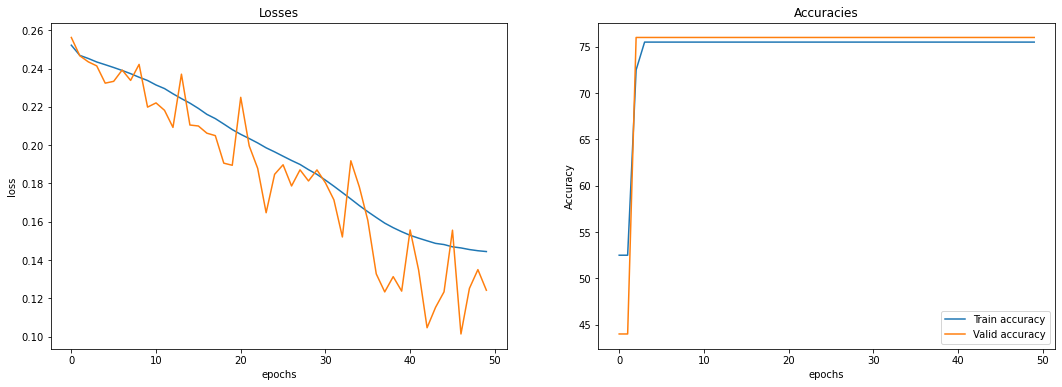

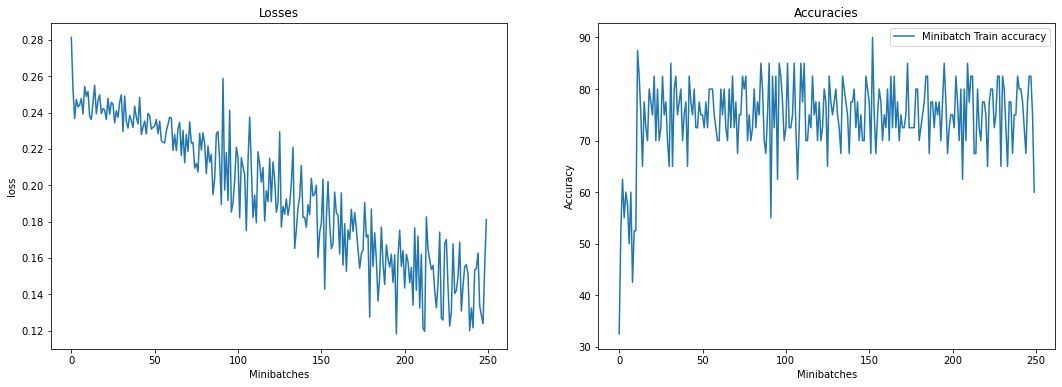

In [80]:
lr = 0.03
bs = 40
datasets, loaders = get_data(bs)
g=0.7
epochs=50 #100
target_history=1
source_history=1
past = 40

activation_collector=activationsCollector(g)
teCalc=teCalculator(target_history, source_history, past, bs)
Xorln = learner(XORnet(), lr, 'adam')
model, opt, loss_fn = Xorln.get_model()


loggers = fit(model, opt, loaders, epochs, activation_collector, teCalc)
lg=loggers['train']
print(f'{lg.epochs} epochs completed, epoch minibatches/samples: {lg.epoch_total_minibatches}/{lg.epoch_total_samples}, total minibs/samples:{lg.minibatches}/{lg.samples}')
plotTraining(loggers, Xorln)
plotTrainingPerMiniBatch(loggers, Xorln)

## Print activations

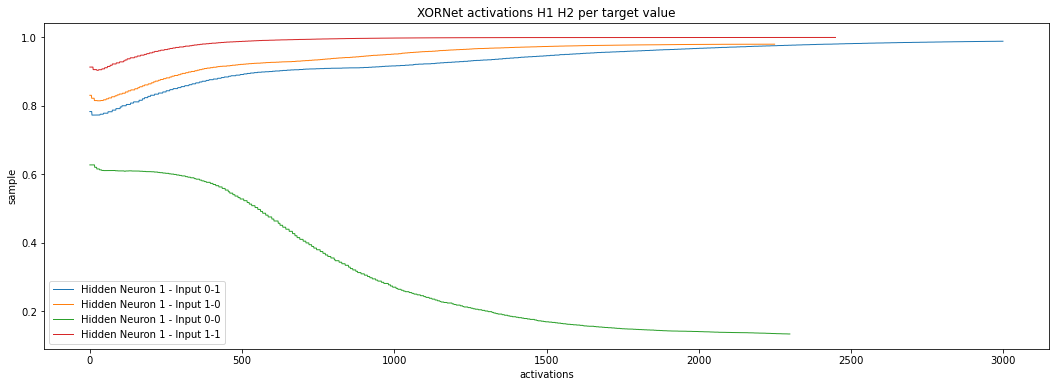

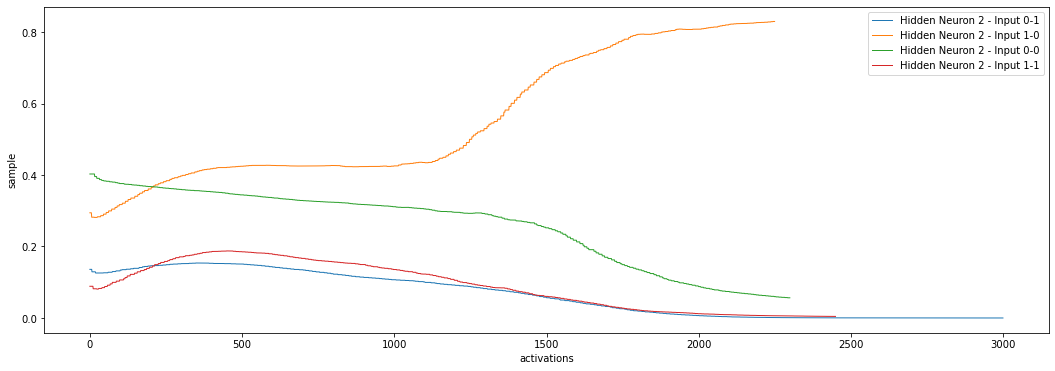

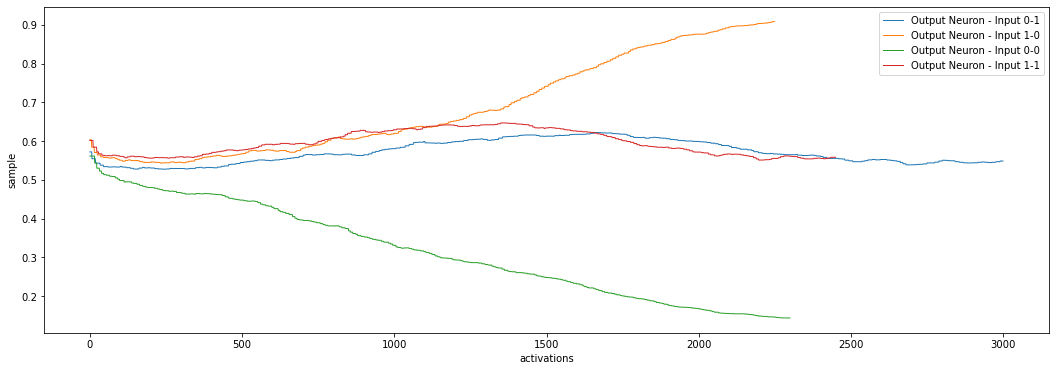

In [81]:
fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('XORNet activations H1 H2 per target value')

neurons = activation_collector.neurons

t0_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.targets[i] == 0]
t1_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.targets[i] == 1]
i01_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 0 and activation_collector.neurons['0-1'][i] == 1 ]
i10_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 1 and activation_collector.neurons['0-1'][i] == 0 ]
i00_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 0 and activation_collector.neurons['0-1'][i] == 0 ]
i11_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 1 and activation_collector.neurons['0-1'][i] == 1 ]

axs.plot([ neurons['1-0'][i] for i in i01_idx ], linewidth=1, label='Hidden Neuron 1 - Input 0-1')
axs.plot([ neurons['1-0'][i] for i in i10_idx ], linewidth=1, label='Hidden Neuron 1 - Input 1-0')
axs.plot([ neurons['1-0'][i] for i in i00_idx ], linewidth=1, label='Hidden Neuron 1 - Input 0-0')
axs.plot([ neurons['1-0'][i] for i in i11_idx ], linewidth=1, label='Hidden Neuron 1 - Input 1-1')
# axs.plot([ activation_collector.neurons['1-0'][i] for i in t1_idx ],  linewidth=1, label='Hidden Neuron 1 - Target 1')

axs.set_xlabel('activations')
axs.set_ylabel('sample')
plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
axs.plot([ neurons['1-1'][i] for i in i01_idx ], linewidth=1, label='Hidden Neuron 2 - Input 0-1')
axs.plot([ neurons['1-1'][i] for i in i10_idx ], linewidth=1, label='Hidden Neuron 2 - Input 1-0')
axs.plot([ neurons['1-1'][i] for i in i00_idx ], linewidth=1, label='Hidden Neuron 2 - Input 0-0')
axs.plot([ neurons['1-1'][i] for i in i11_idx ], linewidth=1, label='Hidden Neuron 2 - Input 1-1')

axs.set_xlabel('activations')
axs.set_ylabel('sample')
plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
axs.plot([ neurons['2-0'][i] for i in i01_idx ], linewidth=1, label='Output Neuron - Input 0-1')
axs.plot([ neurons['2-0'][i] for i in i10_idx ], linewidth=1, label='Output Neuron - Input 1-0')
axs.plot([ neurons['2-0'][i] for i in i00_idx ], linewidth=1, label='Output Neuron - Input 0-0')
axs.plot([ neurons['2-0'][i] for i in i11_idx ], linewidth=1, label='Output Neuron - Input 1-1')

axs.set_xlabel('activations')
axs.set_ylabel('sample')
plt.legend()
plt.show()

## Print TE

In [82]:
print(teCalc.miHistory['1-0-2-0'])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1058585203787218, 0.12135378031372542, 0.09235938389499491, 0.07177830629950363, 0.05482464858165198, 0.09095411519966218, 0.11774369689072076, 0.06049265788394858, 0.1058585203787218, 0.10822465458999425, 0.12135378031372

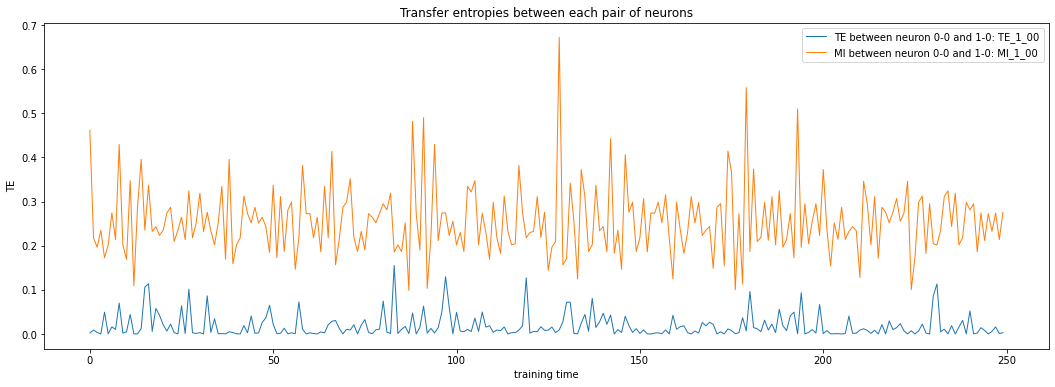

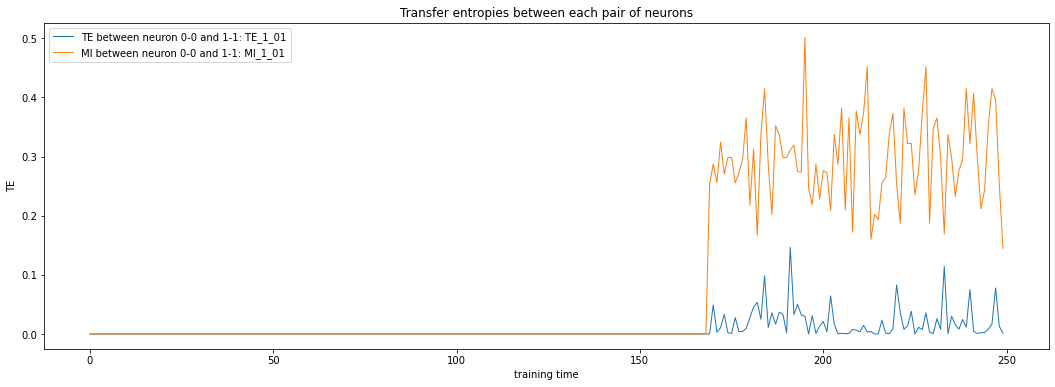

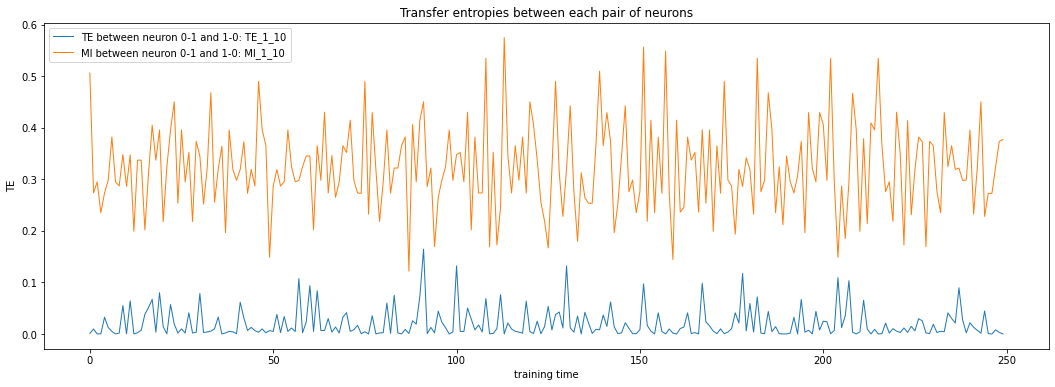

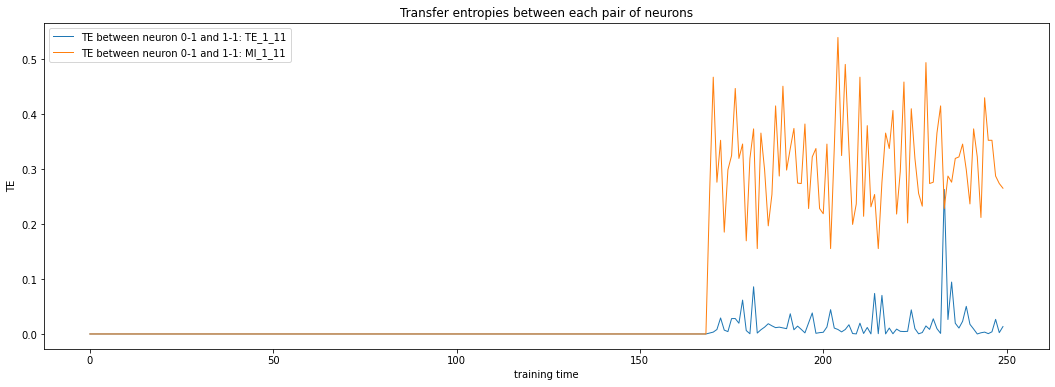

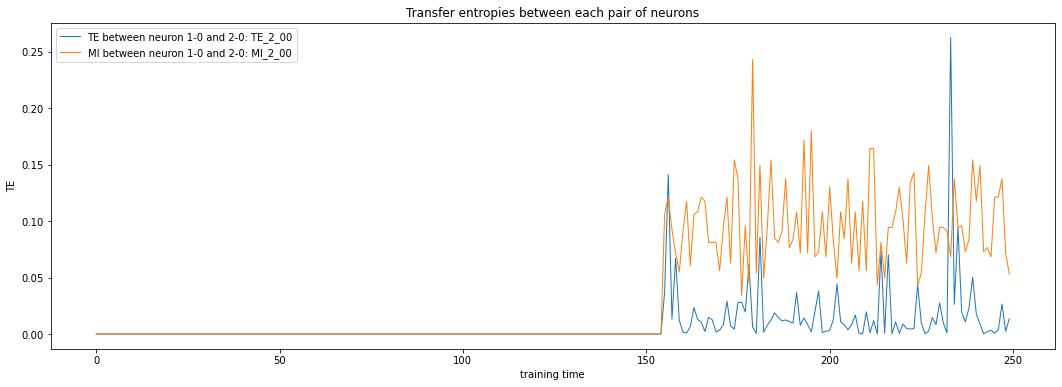

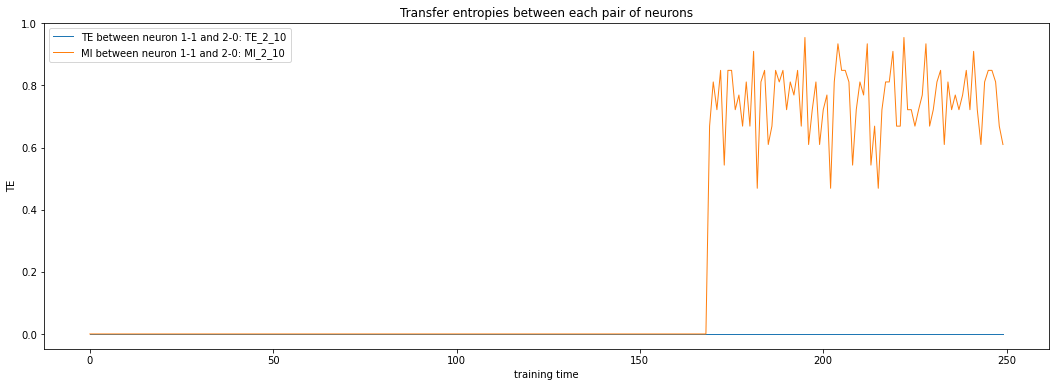

In [87]:
fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('Transfer entropies between each pair of neurons')
axs.set_xlabel('training time')
axs.set_ylabel('TE')

history = teCalc.teHistory
historymi = teCalc.miHistory

axs.plot([ history['0-0-1-0'][i] for i in range(len(history['0-0-1-0'])) ], linewidth=1, label='TE between neuron 0-0 and 1-0: TE_1_00')
axs.plot([ historymi['0-0-1-0'][i] for i in range(len(historymi['0-0-1-0'])) ], linewidth=1, label='MI between neuron 0-0 and 1-0: MI_1_00')

plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('Transfer entropies between each pair of neurons')
axs.set_xlabel('training time')
axs.set_ylabel('TE')

axs.plot([ history['0-0-1-1'][i] for i in range(len(history['0-0-1-1'])) ], linewidth=1, label='TE between neuron 0-0 and 1-1: TE_1_01')
axs.plot([ historymi['0-0-1-1'][i] for i in range(len(historymi['0-0-1-1'])) ], linewidth=1, label='MI between neuron 0-0 and 1-1: MI_1_01')

plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('Transfer entropies between each pair of neurons')
axs.set_xlabel('training time')
axs.set_ylabel('TE')

axs.plot([ history['0-1-1-0'][i] for i in range(len(history['0-1-1-0'])) ], linewidth=1, label='TE between neuron 0-1 and 1-0: TE_1_10')
axs.plot([ historymi['0-1-1-0'][i] for i in range(len(historymi['0-1-1-0'])) ], linewidth=1, label='MI between neuron 0-1 and 1-0: MI_1_10')

plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('Transfer entropies between each pair of neurons')
axs.set_xlabel('training time')
axs.set_ylabel('TE')

axs.plot([ history['0-1-1-1'][i] for i in range(len(history['0-1-1-1'])) ], linewidth=1, label='TE between neuron 0-1 and 1-1: TE_1_11')
axs.plot([ historymi['0-1-1-1'][i] for i in range(len(historymi['0-1-1-1'])) ], linewidth=1, label='TE between neuron 0-1 and 1-1: MI_1_11')

plt.legend()
plt.show()


fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('Transfer entropies between each pair of neurons')
axs.set_xlabel('training time')
axs.set_ylabel('TE')

axs.plot([ history['1-0-2-0'][i] for i in range(len(history['1-0-2-0'])) ], linewidth=1, label='TE between neuron 1-0 and 2-0: TE_2_00')
axs.plot([ historymi['1-0-2-0'][i] for i in range(len(historymi['1-0-2-0'])) ], linewidth=1, label='MI between neuron 1-0 and 2-0: MI_2_00')

plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('Transfer entropies between each pair of neurons')
axs.set_xlabel('training time')
axs.set_ylabel('TE')

axs.plot([ history['1-1-2-0'][i] for i in range(len(history['1-1-2-0'])) ], linewidth=1, label='TE between neuron 1-1 and 2-0: TE_2_10')
axs.plot([ historymi['1-1-2-0'][i] for i in range(len(historymi['1-1-2-0'])) ], linewidth=1, label='MI between neuron 1-1 and 2-0: MI_2_10')

plt.legend()
plt.show()

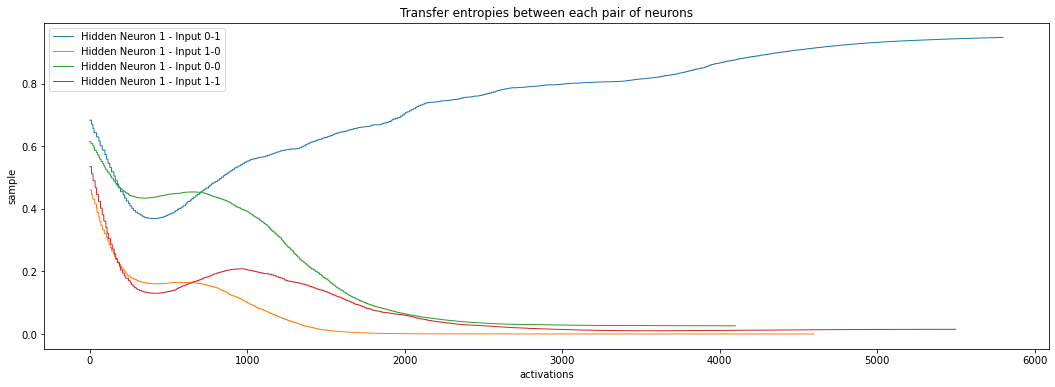

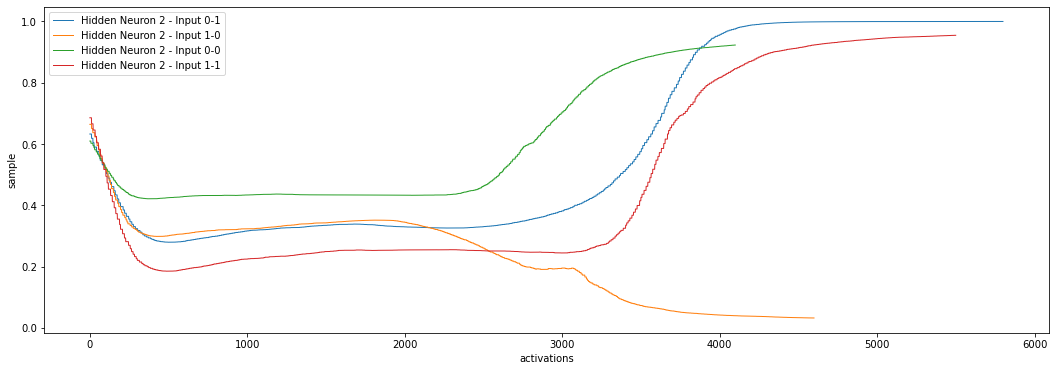

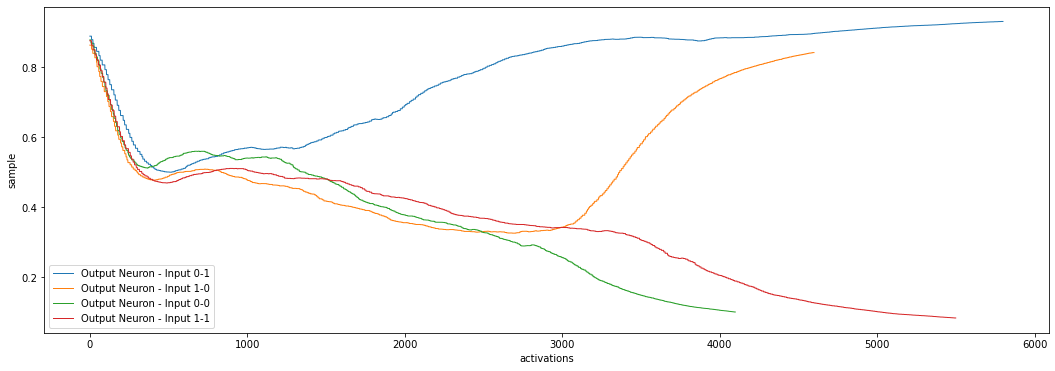

In [31]:
fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('Transfer entropies between each pair of neurons')

t0_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.targets[i] == 0]
t1_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.targets[i] == 1]
i01_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 0 and activation_collector.neurons['0-1'][i] == 1 ]
i10_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 1 and activation_collector.neurons['0-1'][i] == 0 ]
i00_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 0 and activation_collector.neurons['0-1'][i] == 0 ]
i11_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 1 and activation_collector.neurons['0-1'][i] == 1 ]

axs.plot([ activation_collector.neurons['1-0'][i] for i in i01_idx ], linewidth=1, label='Hidden Neuron 1 - Input 0-1')
axs.plot([ activation_collector.neurons['1-0'][i] for i in i10_idx ], linewidth=1, label='Hidden Neuron 1 - Input 1-0')
axs.plot([ activation_collector.neurons['1-0'][i] for i in i00_idx ], linewidth=1, label='Hidden Neuron 1 - Input 0-0')
axs.plot([ activation_collector.neurons['1-0'][i] for i in i11_idx ], linewidth=1, label='Hidden Neuron 1 - Input 1-1')
# axs.plot([ activation_collector.neurons['1-0'][i] for i in t1_idx ],  linewidth=1, label='Hidden Neuron 1 - Target 1')

axs.set_xlabel('activations')
axs.set_ylabel('sample')
plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
axs.plot([ activation_collector.neurons['1-1'][i] for i in i01_idx ], linewidth=1, label='Hidden Neuron 2 - Input 0-1')
axs.plot([ activation_collector.neurons['1-1'][i] for i in i10_idx ], linewidth=1, label='Hidden Neuron 2 - Input 1-0')
axs.plot([ activation_collector.neurons['1-1'][i] for i in i00_idx ], linewidth=1, label='Hidden Neuron 2 - Input 0-0')
axs.plot([ activation_collector.neurons['1-1'][i] for i in i11_idx ], linewidth=1, label='Hidden Neuron 2 - Input 1-1')

axs.set_xlabel('activations')
axs.set_ylabel('sample')
plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
axs.plot([ activation_collector.neurons['2-0'][i] for i in i01_idx ], linewidth=1, label='Output Neuron - Input 0-1')
axs.plot([ activation_collector.neurons['2-0'][i] for i in i10_idx ], linewidth=1, label='Output Neuron - Input 1-0')
axs.plot([ activation_collector.neurons['2-0'][i] for i in i00_idx ], linewidth=1, label='Output Neuron - Input 0-0')
axs.plot([ activation_collector.neurons['2-0'][i] for i in i11_idx ], linewidth=1, label='Output Neuron - Input 1-1')

axs.set_xlabel('activations')
axs.set_ylabel('sample')
plt.legend()
plt.show()

In [32]:
fig, axs= plt.subplotslen(1, 1, figsize=(18, 6))  
plt.title('XORNet activations H1 H2')


axs.plot(activation_collector.neurons['1-0'], linestyle=":", linewidth=1, label='Hidden Neuron 1')

axs.set_xlabel('activations')
axs.set_ylabel('sample')

AttributeError: module 'matplotlib.pyplot' has no attribute 'subplotslen'

In [ ]:
x_in = torch.tensor([[1.0, 1.0]])

In [ ]:
model(x_in)

tensor([[0.0863]], grad_fn=<SigmoidBackward>)

In [ ]:
model.activations

[tensor([[0., 1.]]),
 tensor([[1.4812e-07, 9.9992e-01]], grad_fn=<SigmoidBackward>),
 tensor([[0.3282]], grad_fn=<SigmoidBackward>)]

In [ ]:
model.layers.fc1.weight, model.layers.fc1.bias

NameError: name 'model' is not defined

In [ ]:
model.fc2.weight, model.fc2.bias

(Parameter containing:
 tensor([[-5.4566,  6.3949]], requires_grad=True),
 Parameter containing:
 tensor([2.4287], requires_grad=True))

In [ ]:
type(model.fc1)

torch.nn.modules.linear.Linear

# optimizer

http://mcneela.github.io/machine_learning/2019/09/03/Writing-Your-Own-Optimizers-In-Pytorch.html   


In [ ]:
from torch.optim import Optimizer
class SGDWithTE(Optimizer):
    '''
    Implement backpropagation algorithm with a twist
    Using inter-neuron transfer entropy to change the weight update
    Wl:= Wl − η∆l(1 − tel)
    '''